This notebook contains code to calculate the burden of deleterious variation from inherited STRs

In [1]:
%pylab inline

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from matplotlib import pyplot as plt
import sys
import random
sys.path.append("/storage/BonnieH/selection_project/joint_method")
from Joint_method_functions import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
# See /storage/BonnieH/selection_project/1000genomes/euro_allele_freqs/Generate_sample_info_txt.py for
# script extracting a sample's genotype information from the merged VCF "EUR_sans_FIN_filtered_w_sistr2_scores.vcf.gz" 
# that contains information regarding all samples

# Perform the following command to obtain genotypes for each STR for a given individual (only keep STRs with SISTR2 scores)
# Example command for individual NA12864
'''
awk 'NR==FNR{c[$1"a"$2]++;next};c[$1"a"$2] > 0 {print $1"\t"$2"\t"$3"\t"$4}' /storage/BonnieH/selection_project/1000genomes/euro_allele_freqs/1kg_allele_freqs_with_sistr2_scores_no_chr.txt /storage/BonnieH/selection_project/1000genomes/euro_allele_freqs/NA12864.txt > /storage/BonnieH/selection_project/1000genomes/euro_allele_freqs/NA12864_filtered.txt

'''

# Note - The file /storage/BonnieH/selection_project/1000genomes/euro_allele_freqs/EUR_sans_FIN_filtered_w_sistr2_scores.vcf.gz was obtained using the command: 
'''
bcftools view --regions-file /storage/BonnieH/selection_project/1000genomes/euro_allele_freqs/1kg_with_sistr2_scores.txt /storage/BonnieH/selection_project/1000genomes/euro_allele_freqs/EUR_sans_FIN_filtered.vcf.gz | bgzip -c > /storage/BonnieH/selection_project/1000genomes/euro_allele_freqs/EUR_sans_FIN_filtered_w_sistr2_scores.vcf.gz
'''

'\nbcftools view --regions-file /storage/BonnieH/selection_project/1000genomes/euro_allele_freqs/1kg_with_sistr2_scores.txt /storage/BonnieH/selection_project/1000genomes/euro_allele_freqs/EUR_sans_FIN_filtered.vcf.gz | bgzip -c > /storage/BonnieH/selection_project/1000genomes/euro_allele_freqs/EUR_sans_FIN_filtered_w_sistr2_scores.vcf.gz\n'

In [3]:
# Read in joint results
joint_results = {}
sistr2_scores_file = open('/storage/BonnieH/selection_project/analysis/SISTR2_scores_by_motif.txt', 'r')
sistr2_scores_file.readline()
for line in sistr2_scores_file:
    info = line.strip().split('\t')
    period = int(info[0])
    optimal_ru = int(info[1])
    motif = info[2]
    est_a = float(info[4])
    est_b = float(info[5])
    joint_results[(period,optimal_ru,motif)] = (est_a,est_b)
sistr2_scores_file.close()

In [4]:
# Given a file with simulation results, return a dictionary where the key is the rounded s value and the value is a 
# list of [s, allele_freqs] pairs
def getAlleleFreqsTable(abcFile):
    abc_file = open(abcFile, 'r')
    header = abc_file.readline().strip().split('\t')
    
    # Find column in file that has allele freqs
    freqs_column = 0
    
    # Dictionary of allele freqs
    dic = {}
    for i in range(0, len(header)):
        if header[i] == 'freqs':
            freqs_column = i

    for line in abc_file:
        info = line.strip().split('\t')
        s = float(info[0])
        freq_string = info[freqs_column]
        allele_freqs = [float(freq) for freq in freq_string.split(',')]
        #print(allele_freqs)
        s_round = get_LRT_bin(s)
        if s_round not in dic:
            dic[s_round] = []
        dic[s_round].append([s, allele_freqs])
        
    return dic

In [5]:
%%time
# Preprocess ABC lookup table
# Get ABC tables
ABC_tables = {}
    
mut_setting_folder_name = {}
mut_setting_folder_name[2] = 'eurodem_prior2_dinuc_'
mut_setting_folder_name[3] = 'eurodem_prior2_trinuc_'
mut_setting_folder_name[4] = 'eurodem_prior2_tetranuc_'
    
mut_settings = {}
mut_settings[2] = ['a','b','c','d','e','f']
mut_settings[3] = ['a','b','c','d','e','f','g']
mut_settings[4] = ['a','b','c','d','e','f','g']
    
per_list = [2,3,4]

opt_allele_dic = {}
opt_allele_dic[2] = [11,12,13,14,15,16,17,18,19,20] 
opt_allele_dic[3] = [5,6,7,8,9,10,11,12,13] 
opt_allele_dic[4] = [7,8,9,10] 

# Go through each period, opt allele, mutation setting combination to create ABC lookup table
for per in per_list:

    folder_prefix = mut_setting_folder_name[per]
        
    for mut_setting in mut_settings[per]:
        for opt in opt_allele_dic[per]:
            file = '/gymreklab-tscc/bonnieh/abc/results/' + folder_prefix + mut_setting + '_1kg_euro/' + str(per) + '_' + str(opt) + '.txt'

            ABC_tables[(per,opt,mut_setting)] = getAlleleFreqsTable(file)

CPU times: user 18.4 s, sys: 1.25 s, total: 19.6 s
Wall time: 20.2 s


In [6]:
# Get the inherited s value given list of allele freqs for different s, the difference from the optimal allele, 
# and the (a, b) parameters of the gamma distribution from which s is drawn
def getInheriteds(list_freqs, diff, a, b):
    
    # Note: We are returning the s value unless
    # When the difference from the optimal allele is 0, we arbitrarily return 99999
    # When the difference from the optimal allele is >12 or <-12, we arbitrarily return 999999 
    # When we draw/simulate 1000 freqs and still do not simulate the variant, we arbitrarily return 9999999
    if diff == 0:
        return 99999
    if diff > 12 or diff < -12:
        return 999999
    
    # Get table of s and mutant allele's frequency in the population
    
    population = []
    weights = []
    
    for i in range(0, 1000):
        s_val = np.random.gamma(a, b)
        if s_val > 1:
            s_val = 1
                
        s_round = get_LRT_bin(s_val)
                
        # Pick random allele frequency
            
        freqs_for_s = list_freqs[s_round]
        random_freqs = random.choice(freqs_for_s)
        
        # Note: There are 25 possible alleles in the allele frequency distribution, with the optimal allele in the 
        # middle of the list. Thus, to get the appropriate variant, we index at diff + 12
        if random_freqs[1][diff + 12] > 0:
            population.append(s_val)
            weights.append(random_freqs[1][diff + 12])
            
    # Arbitrarily return 9999999 when we draw/simulate 1000 freqs and still do not simulate the variant
    if len(population) < 1:
        return 9999999
    
    # Make weights add up to 1
    normalized_weights = []
   
    for elem in weights:
        normalized_weights.append(elem/sum(weights))
        
    s = random.choices(population, weights = normalized_weights, k = 1)
    #print(s)
    return s[0]

In [7]:
%%time
sample = 'NA10845' # Change sample name based on the sample you would like to analyze

# Calculate burden from standing variation using joint scores
sample_info_file = open('/storage/BonnieH/selection_project/1000genomes/euro_allele_freqs/' + sample + '_filtered.txt', 'r') 

# Joint scores
sistr_scores_file = open('/storage/BonnieH/selection_project/1000genomes/euro_allele_freqs/1kg_allele_freqs_with_sistr2_scores_no_chr.txt', 'r')

# Column headers for above file: chrom, pos, per, optimal allele, motif

burden_list_joint = [] # List of burdens
diff_list = [] # List of differences between optimal allele and individual's genotype
motif_list = []
opt_allele_list = []
count_loci = 0
num_times_list = [] # List of number of allele frequencies drawn before finding variant
num_not_found = 0 # Number of variants where when we draw/simulate 20000 freqs and still do not simulate the variant
num_not_exist = 0 # Number of variants where the difference from the optimal allele is >12 or <-12

motif_dic = {}
motif_dic[2] = ['AC','AG','AT'] 
motif_dic[3] = ['ACC','AGG','AGC','CCG','AAG','AAC','ATC','AAT'] 
motif_dic[4] = ['AAGG','AAAT','ATCC','AATC','AAAC','AATG','ACAT','AGAT','AAAG'] 

mut_setting = {}
mut_setting['AC'] = 'e'
mut_setting['AG'] = 'e'
mut_setting['AT'] = 'd'
for mot in motif_dic[3]:
    mut_setting[mot] = 'e'
for mot in ['AAAG', 'AAGG', 'AGAT']:
    mut_setting[mot] = 'b'
for mot in ['ACAT', 'AAAT']:
    mut_setting[mot] = 'c'
for mot in ['AATC', 'AATG', 'ATCC', 'AAAC']:
    mut_setting[mot] = 'd'

burden_by_class = {}

# Exclude KS score <= 50
exclusion_file = open('Exclude_KS_Score.txt', 'r') 
exclusion_list = []
for line in exclusion_file:
    info = line.strip().split('\t')
    optimal_allele = int(info[0])
    motif = info[1]
    exclusion_list.append((optimal_allele, motif))
exclusion_file.close()

for line1, line2 in zip(sistr_scores_file, sample_info_file):
    
    # Get information from line - joint scores file
    info = line1.strip().split('\t')
    chrom = info[0]
    start = int(info[1])
    per = int(info[2])
    opt_allele = int(info[3])
    motif = info[4]
        
    # Get information about genotypes
    info = line2.strip().split('\t')
    chromosome = info[0]
    pos = int(info[1])
    if chromosome != chrom or start != pos:
        print('Does not match')
        print((chrom, chromosome))
        print((start, pos))
    geno1 = int(info[2])
    geno2 = int(info[3])
        
    if geno1 != 0 and geno2 != 0 and (opt_allele,motif) not in exclusion_list:
            
        count_variant_alleles = 0
        count_loci = count_loci + 1
        diff1 = geno1 - opt_allele
        diff2 = geno2 - opt_allele
            
        # Calculate burden

        if (per, opt_allele, motif) in joint_results:
                
            # Joint scores
            s_val1 = 0
            s_val2 = 0
            
            a = joint_results[(per, opt_allele, motif)][0]
            b = joint_results[(per, opt_allele, motif)][1]
           
            # Get allele frequency dictionary (dic_freqs) from ABC lookup table
            setting = mut_setting[motif]
            dic_freqs = ABC_tables[(per,opt_allele,setting)]
            
            # Get inherited s values
            s_val1 = getInheriteds(dic_freqs, diff1, a, b)
            s_val2 = getInheriteds(dic_freqs, diff2, a, b)
            
            # Calculate burdens    
            burden1 = abs(diff1*s_val1)
            burden2 = abs(diff2*s_val2)
            if burden1 > 1:
                burden1 = 1
            if burden2 > 1:
                burden2 = 1
                
            if diff1 != 0:
                # See getInheriteds function for explanation of these numbers
                if s_val1 > 2:
                    if s_val1 == 999999:
                        num_not_exist = num_not_exist + 1
                    if s_val1 == 9999999:
                        num_not_found = num_not_found + 1
                    burden1 = 0
                    
                diff_list.append(diff1)
                motif_list.append(motif)
                opt_allele_list.append(opt_allele)
                count_variant_alleles = count_variant_alleles + 1
                if burden1 < 10**-5:
                    burden1 = 0
                burden_list_joint.append(burden1)
                
            if diff2 != 0:
                if s_val2 > 2:
                    if s_val2 == 999999:
                        num_not_exist = num_not_exist + 1
                    if s_val2 == 9999999:
                        num_not_found = num_not_found + 1
                    burden2 = 0
                    
                diff_list.append(diff2)
                motif_list.append(motif)
                opt_allele_list.append(opt_allele)
                count_variant_alleles = count_variant_alleles + 1
                if burden2 < 10**-5:
                    burden2 = 0
                burden_list_joint.append(burden2)
                    
            # Add information to burden_by_class dictionary
            if (motif, opt_allele) not in burden_by_class:
                burden_by_class[(motif, opt_allele)] = [2, count_variant_alleles, burden1 + burden2]
                    
            else:
                burden_by_class[(motif, opt_allele)][0] = burden_by_class[(motif, opt_allele)][0] + 2
                burden_by_class[(motif, opt_allele)][1] = burden_by_class[(motif, opt_allele)][1] + count_variant_alleles
                burden_by_class[(motif, opt_allele)][2] = burden_by_class[(motif,opt_allele)][2] + burden1 + burden2
                
sistr_scores_file.close()
sample_info_file.close()

print("%s STR Reduction in Fitness" %(sample))
print("Standing variation burden = %.2f (Calculated from %d alleles)" %(np.sum(burden_list_joint), len(burden_list_joint)))
print("Total number of alleles: %d" %(count_loci*2))


# Write burden results to file
results_file = open('./inherited_burden/'+sample+"_inherited_burden_041522.txt","w")
results_file.write("Variation from optimal allele" + "\t" + "Inherited burden" + "\t" + "Motif" + "\t" + "Optimal allele" + "\n")
for i in range(0, len(burden_list_joint)):
    results_file.write(str(diff_list[i])+"\t"+str(burden_list_joint[i])+"\t"+str(motif_list[i])+"\t"+str(opt_allele_list[i])+"\n")
results_file.close()


# Write results by class to file
results_file = open('./inherited_burden/'+sample+"_burden_by_class_041522.txt","w")

results_file.write("Motif" + "\t" + "Optimal_allele" + "\t" + "Total_num_alleles" + "\t" + "Num_variant_alleles" + "\t" + "Burden" + "\n")
for str_class in burden_by_class:
    results_file.write(str(str_class[0])+"\t"+str(str_class[1])+"\t"+str(burden_by_class[str_class][0])+"\t"+str(burden_by_class[str_class][1])+"\t"+str(burden_by_class[str_class][2])+"\n")
results_file.close()

NA10845 STR Reduction in Fitness
Standing variation burden = 8.56 (Calculated from 21526 alleles)
Total number of alleles: 53468
CPU times: user 27min 4s, sys: 2.15 s, total: 27min 6s
Wall time: 27min 4s


In [8]:
print(num_not_exist)
print(num_not_found)

120
114


Text(0.5, 1.0, 'NA10845 \n Number of alleles with variation: 21526/53468')

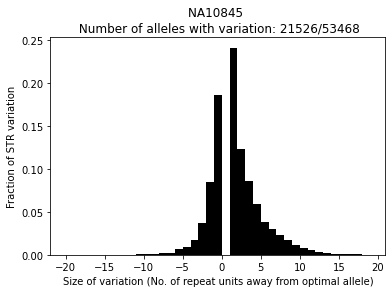

In [9]:
plt.hist(diff_list, color='black', bins = np.arange(-20,20,1), weights = np.ones_like(diff_list)/len(diff_list))
plt.xlabel('Size of variation (No. of repeat units away from optimal allele)')
plt.ylabel('Fraction of STR variation')
plt.title('%s \n Number of alleles with variation: %d/%d'%(sample, len(diff_list), count_loci*2))
#print(diff_list)

Text(0.5, 1.0, 'Joint additive fitness value versus number of simulations performed')

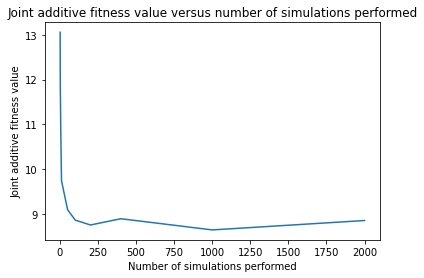

In [10]:
xAxis = [1,2,3,5,10,50,100,200,400,1000,2000]
yAxis = [13.06,11.81,11.58,10.89,9.74,9.09,8.86,8.75,8.89,8.64,8.85]
plt.plot(xAxis,yAxis)
plt.xlabel('Number of simulations performed')
plt.ylabel('Joint additive fitness value')
plt.title('Joint additive fitness value versus number of simulations performed')